In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from environment import get_all_scenes
from HierarchicalPRM_2 import HierarchicalPlanner
from lectures.IPLazyPRM import LazyPRM
from lectures.IPBasicPRM import BasicPRM
from lectures.IPEnvironment import CollisionChecker
from scipy.spatial.distance import euclidean
from matplotlib.patches import Polygon as MplPolygon

In [2]:
# ---- Konfiguration ----
config_high = {
    "ntry": 30,
}

config_low_lazy = {
    "initialRoadmapSize": 15,
    "updateRoadmapSize": 10,
    "kNearest": 8,
    "maxIterations": 10
}

config_low_basic = {
    "numNodes": 30,
    "radius": 4
}

scenes = get_all_scenes()
# %%
# 📁 Ordner anlegen
plot_dir = "plots_hierarchical"
results_dir = "benchmark_results"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [3]:
def draw_obstacles(ax, obstacles):
    for ob in obstacles:
        patch = MplPolygon(list(ob.exterior.coords), closed=True, color='red', alpha=0.4)
        ax.add_patch(patch)

def run_benchmark(subplanner_type, config_local):
    results = []

    print(f"\n🔁 Starte Benchmarks mit Subplanner: {subplanner_type}")
    for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
        print(f"\n🔍 Szene: {scene_name}")
        start = [float(x) for x in start_pos]
        goal = [float(x) for x in goal_pos]

        collision_checker = CollisionChecker(scene, limits)
        obstacles = list(scene.values())

        # Dummy-Figure für Visualisierung
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(*limits[0])
        ax.set_ylim(*limits[1])
        ax.set_aspect("equal")
        ax.set_title(f"{scene_name} – {subplanner_type}")

        # --- Zeichne Hindernisse ---
        draw_obstacles(ax, obstacles)

        # Init Planner
        planner = HierarchicalPlanner(
            checker=collision_checker,
            limits=limits,
            obstacles=obstacles,
            ax=ax,
            planner_type=subplanner_type.lower(),  # 'lazy' oder 'basic'
            connection_radius=15,
            search_margin=5
        )
        planner.planner_config.update(config_local)

        t0 = time.time()
        path = planner.planPath(start, goal, {
            "ntry": config_high["ntry"],
            "subPlannerConfig": config_local
        })
        planner.draw_debug(ax)
        t1 = time.time()

        coords = [tuple(p) for p in path if isinstance(p, (list, tuple)) and len(p) == 2] if isinstance(path, list) else []
        euclidean_length = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:])) if coords else 0

        result = {
            "planner": f"Hierarchical-{subplanner_type}",
            "scene": scene_name,
            "hasPath": bool(coords),
            "length": len(coords),
            "euclidean_length": euclidean_length,
            "time": t1 - t0,
            "nodes": len(planner.guards),
            "local_attempts": len(planner.debug_stats),
            "successful_connections": sum(1 for e in planner.debug_stats if e["success"]),
        }
        results.append(result)

        if not coords:
            print(f"❌ Kein Pfad gefunden in Szene: {scene_name}")
            ax.set_title(f"{scene_name} – Kein Pfad gefunden ({subplanner_type})", color='red')
        else:
            print(f"✅ Pfad gefunden in Szene: {scene_name}, Länge: {len(coords)}")
            ax.plot(*zip(*coords), color='green', linewidth=2, label='Finaler Pfad')

        # Optional: Debug-Zeichnung (Pfade, Knoten etc.)
        if hasattr(planner, "draw_debug"):
            planner.draw_debug(ax)

        ax.plot(*start, marker='o', color='blue', label='Start')
        ax.plot(*goal, marker='x', color='black', label='Ziel')
        ax.legend()
        plt.show()

    return results


🔁 Starte Benchmarks mit Subplanner: Lazy

🔍 Szene: U-Shape


TypeError: list indices must be integers or slices, not str

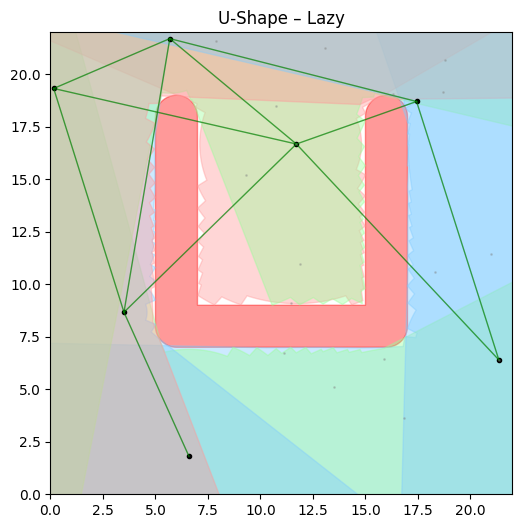

In [4]:
# 🔁 Beide Runs durchführen
all_results = []

lazy_results = run_benchmark("Lazy", config_low_lazy)
pd.DataFrame(lazy_results).to_csv(os.path.join(results_dir, "Hierarchical-Lazy_results.csv"), index=False)
all_results.extend(lazy_results)

basic_results = run_benchmark("Basic", config_low_basic)
pd.DataFrame(basic_results).to_csv(os.path.join(results_dir, "Hierarchical-Basic_results.csv"), index=False)
all_results.extend(basic_results)

pd.DataFrame(all_results).to_csv(os.path.join(results_dir, "Hierarchical_ALL_results.csv"), index=False)

print("\n✅ Alle Benchmarks abgeschlossen.")

In [ ]:
# Visualisierung
result_df = pd.DataFrame(all_results)
for scene in result_df["scene"].unique():
    df = result_df[result_df["scene"] == scene]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    width = 0.2
    idx = np.arange(len(df))

    ax1.bar(idx, df["length"], width, label="Path Length", color="#1f77b4")
    ax1.set_ylabel("Path Length", color="#1f77b4")
    ax1.tick_params(axis='y', labelcolor="#1f77b4")

    ax2 = ax1.twinx()
    ax2.bar(idx + width, df["euclidean_length"], width, label="Eucl. Length", color="#2ca02c")
    ax2.set_ylabel("Euclidean Length", color="#2ca02c")
    ax2.tick_params(axis='y', labelcolor="#2ca02c")

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.2))
    ax3.bar(idx + 2 * width, df["time"], width, label="Time (s)", color="#d62728")
    ax3.set_ylabel("Time [s]", color="#d62728")
    ax3.tick_params(axis='y', labelcolor="#d62728")

    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('axes', 1.4))
    ax4.bar(idx + 3 * width, df["roadmap_size"], width, label="Roadmap Size", color="#9467bd")
    ax4.set_ylabel("Roadmap Size", color="#9467bd")
    ax4.tick_params(axis='y', labelcolor="#9467bd")

    ax1.set_xticks(idx + 1.5 * width)
    ax1.set_xticklabels(df["planner"].values)
    ax1.set_title(f"Benchmark-Auswertung: {scene}")

    handles, labels = [], []
    for ax in [ax1, ax2, ax3, ax4]:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax1.legend(handles, labels, loc="upper left", fontsize="small")

    plt.tight_layout()
    plt.show()

In [ ]:
# --- Pfadplanung ---
hier_planner = HierarchicalPlanner(
    scene=scenes[0][1][0],  # Nimm die erste Szene
    limits=scenes[0][1][1],
    GlobalPlannerClass=VisibilityPRM,
    LocalPlannerClass=LazyPRM,  # Oder BasicPRM
    config_global=config_high,
    config_local=config_low_lazy  # Oder config_low_basic
)

start = [list(scenes[0][1][2][0])]
goal = [list(scenes[0][1][2][1])]
path = hier_planner.plan_path(start, goal)
if not path:
    print("❌ Kein Pfad gefunden.")
else:
    print("✅ Pfad gefunden mit", len(path), "Punkten")

    # Korrekte Reihenfolge der Initialisierung für die Visualisierung
    hier_planner.solution_path = path  # Statt final_path
    hier_planner.graph = hier_planner.global_planner.graph  # Verwende direkt den globalen Planer-Graph

    collision_checker = CollisionChecker(hier_planner.scene, hier_planner.limits)
    visualize_hierarchical_planning(hier_planner, collision_checker, hier_planner.config_local)


In [ ]:
# --- Jede Szene durchlaufen ---
config_low = {
    "initialRoadmapSize": 100,
    "kNearest": 10,
    "maxIterations": 20,
    "updateRoadmapSize": 50
}
for name, (scene, limits, (start_tuple, goal_tuple)) in scenes:
    print(f"\n🔄 Verarbeite Szene: {name}")

    # Start- und Zielposition ins passende Format bringen
    start = [list(start_tuple)]
    goal = [list(goal_tuple)]

    # Kollisionserkennung
    collision_checker = CollisionChecker(scene, limits)

    # Planer initialisieren
    hier_planner = HierarchicalPlanner(
        scene=scene,
        limits=limits,
        GlobalPlannerClass=VisibilityPRM,
        LocalPlannerClass=LazyPRM,
        config_global=config_high,
        config_local=config_low
    )

    # Pfadplanung
    path = hier_planner.plan_path(start, goal)
    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {name}")
        continue
    else:
        print(f"✅ Pfad gefunden in Szene: {name}, Länge: {len(path)}")

    # Visualisierung vorbereiten (optional, kann deaktiviert werden)
    hier_planner.solution_path = path
    hier_planner.graph = hier_planner.global_planner.graph
    visualize_hierarchical_planning(hier_planner, collision_checker, config_low)

    # Alternativ: Ergebnisse speichern oder zusammenfassen